### Requirements (to-do-list)
CHECK --> Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

CHECK --> Apply a distortion correction to raw images.

Use color transforms, gradients, etc., to create a thresholded binary image.

Apply a perspective transform to rectify binary image ("birds-eye view").

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
#%matplotlib inline
%matplotlib qt

### Utility function to print side-by-sides

In [19]:
def display_two(a,b,ta,tb):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(a,cmap='gray')
    ax1.set_title(ta, fontsize=30)
    ax2.imshow(b,cmap='gray')
    ax2.set_title(tb, fontsize=30)
def display_three(R,G,B,t1,t2,t3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    f.tight_layout()
    ax1.imshow(R,cmap='gray')
    ax1.set_title(t1, fontsize=30)
    ax2.imshow(G,cmap='gray')
    ax2.set_title(t2, fontsize=30)
    ax3.imshow(B,cmap='gray')
    ax3.set_title(t3, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Loop through calibration images and find the chessboard corners on each image

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')

#coordinates of the board corners
objpoints = []
imgpoints = []
COLUMNS_TO_FIND = 6
objp = np.zeros((COLUMNS_TO_FIND*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:COLUMNS_TO_FIND].T.reshape(-1,2)

start = time.time()
for fname in images:
    
    img = mpimg.imread(fname)    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners = cv2.findChessboardCorners(gray, (9,COLUMNS_TO_FIND),None)
    
    if ret == True:    
        imgpoints.append(corners)
        objpoints.append(objp)

        #img = cv2.drawChessboardCorners(img, (9,5), corners, ret)
        
        #print("corners 0 0 ", corners[0][0])

        #print(len(corners),corners, ret)
fini = time.time()
print("It took {} seconds".format(str(fini-start)))

It took 2.6406407356262207 seconds


### Below returns distortion coef, camera matrix, rotation vec, translation vec 

In [3]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None, None)

In [4]:
img = mpimg.imread('./camera_cal\\calibration1.jpg')
undist = np.copy(img)
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
undistorted = cv2.undistort(gray, mtx, dist, None, mtx)

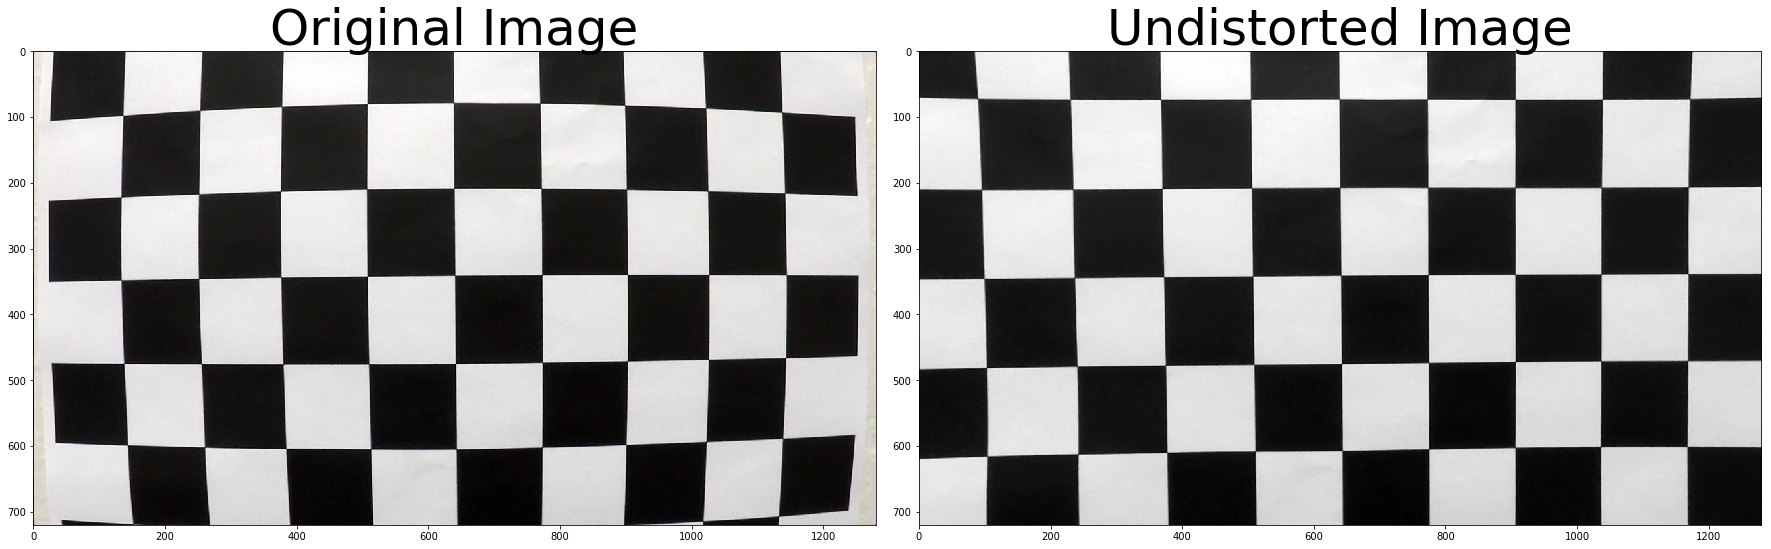

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted,cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Histogram on 33. Finding the Lanes

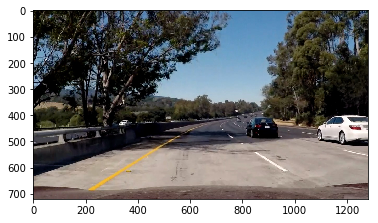

In [26]:
image_for_HLS = mpimg.imread('./test_images/test5.jpg')
plt.imshow(image_for_HLS)


## Convert to HLS and get the S and do a thresholding on it

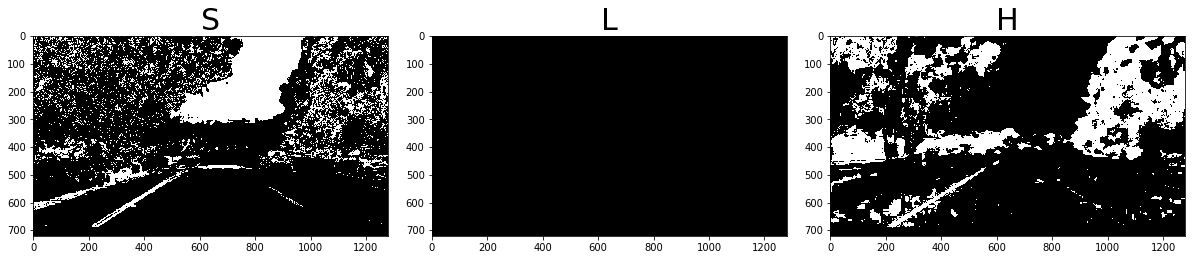

In [25]:
#image_for_HLS = mpimg.imread('./test_images/straight_lines1.jpg')
image_for_HLS = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(image_for_HLS, cv2.COLOR_RGB2HLS)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh_s = (90, 220)
S_binary = np.zeros_like(S)
S_binary[(S > thresh_s[0]) & (S <= thresh_s[1])] = 1

thresh_h = (15,50)
H_binary = np.zeros_like(H)
H_binary[(H > thresh_h[0]) & (H <= thresh_h[1])] = 1

thresh_l = (0,100)
L_binary = np.zeros_like(L)
L_binary[ (L > thresh_l[0]) & (L < thresh_l[1])]


display_three(S_binary,L_binary,H_binary,"S",'L','H')

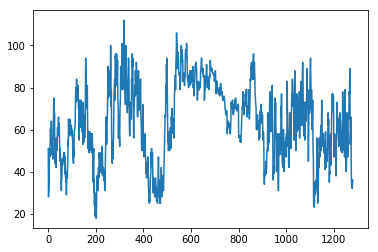

In [17]:
img = S_binary
histogram = np.sum(img[img.shape[0]//3:,:], axis=0)
plt.plot(histogram)

## Direction Threshold

In [55]:
def direction_threshold(img, sobel_kernel=15, thresh=(0, np.pi/3)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_RGB2GRAY)    
    
    sobel = None
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobelx,sobely = np.absolute(sobelx), np.absolute(sobely)
    direction_of_gradient = np.arctan2( sobely, sobelx)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(direction_of_gradient)
    
    #make anything with the inputted thresholds 1
    sxbinary[(direction_of_gradient >= thresh_min) & (direction_of_gradient <= thresh_max)] = 1
    
    return sxbinary

### Sobel Function

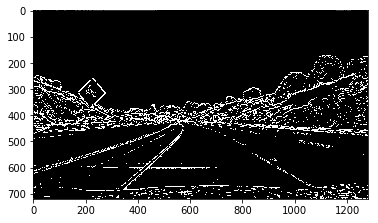

In [58]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255) ):
    
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_BGR2GRAY)
    
    assert orient== 'x' or orient=='y'
    
    sobel = None
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    #print(abs_sobel)
    #convert to 8-bit 0..255 image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    #numpy zeros_like --> Returns an array of zeros with the same shape and type as a given array.
    thresh_min = thresh[0]
    thresh_max = thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(scaled_sobel)
    
    #make anything with the inputted thresholds 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary
#call with 20.. 100
to_get_edges = cv2.imread('./test_images/test2.jpg')
got_edges = abs_sobel_thresh(to_get_edges, orient='y', thresh=(20,100) )
plt.imshow(got_edges,cmap='gray')

### From course Content !!!

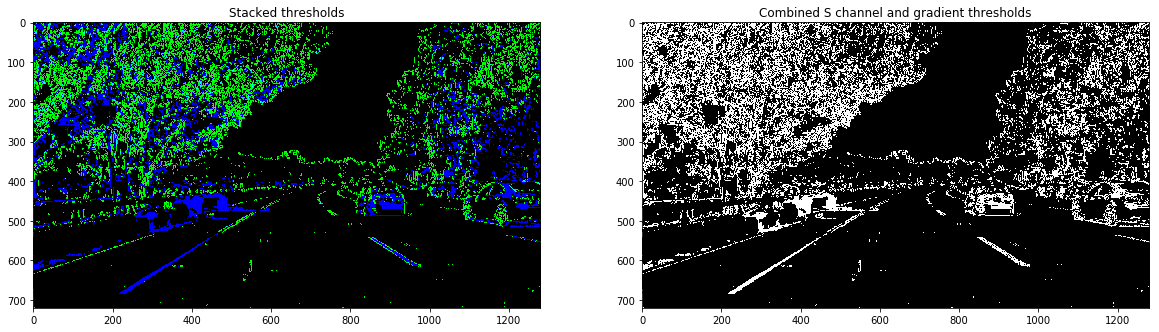

In [61]:
img  = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 185
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

#direction_threshold(img, sobel_kernel=15, thresh=(0, np.pi/3))
